In [2]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from tqdm.auto import tqdm
import torch

warnings.filterwarnings('ignore')
%matplotlib inline

In [24]:
class Module(object):
    def __init__ (self):
        self._output = None
        self._input_grad = None
        self.training = True
    
    def forward(self, input):
        self._output = self._compute_output(input)
        return self._output

    def backward(self, input, output_grad):
        self._input_grad = self._compute_input_grad(input, output_grad)
        self._update_parameters_grad(input, output_grad)
        return self._input_grad

    def _compute_output(self, input):
        raise NotImplementedError   

    def _compute_input_grad(self, input, output_grad):
        raise NotImplementedError
    
    def _update_parameters_grad(self, input, output_grad):
        pass
    
    def zero_grad(self): 
        pass
        
    def get_parameters(self):
        return []
        
    def get_parameters_grad(self):
        return []
    
    def train(self):
        self.training = True
    
    def evaluate(self):
        self.training = False
    
    def __repr__(self):
       return "Module"

## 1. Conv2d

* input: `batch_size x in_channels x h x w`
* output: `batch_size x out_channels x h x w`

You should implement something like pytorch Conv2d layer with `stride=1` and zero-padding outside of image using `scipy.signal.correlate` function.

**Practical notes:**

* While the layer name is "convolution", the most of neural network frameworks (including tensorflow and pytorch) implement operation that is called [correlation](https://en.wikipedia.org/wiki/Cross-correlation#Cross-correlation_of_deterministic_signals) in signal processing theory. **So don't use** `scipy.signal.convolve` since it implements convolution in terms of signal processing.
* It may be convenient to use numpy.pad for zero-padding.
* It's rather ok to implement convolution over 4d array using 2 nested loops: one over batch size dimension and another one over output filters dimension

In [25]:
import scipy as sp
import scipy.signal

class Conv2d(Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(Conv2d, self).__init__()
        assert kernel_size % 2 == 1, kernel_size
       
        stdv = 1./np.sqrt(in_channels)
        self.W = np.random.uniform(-stdv, stdv, size = (out_channels, in_channels, kernel_size, kernel_size))
        self.b = np.random.uniform(-stdv, stdv, size=(out_channels,))
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)
        
    def _compute_output(self, input):
        pad_size = self.kernel_size // 2
        n, c, w, h = input.shape
        input = np.pad(input, ((0, 0), (0, 0), (pad_size, pad_size), (pad_size, pad_size)), 
                       'constant', constant_values=0)
        self._output = np.zeros((n, self.out_channels, w, h))
        self._output += np.repeat(self.b[np.newaxis, :, np.newaxis, np.newaxis], n, axis=0)
        for sample_index in range(n):
            for out_channel_index in range(self.out_channels):
                for in_channel_index in range(self.in_channels):
                    self._output[sample_index][out_channel_index] += \
                        scipy.signal.correlate2d(input[sample_index][in_channel_index], 
                                                 self.W[out_channel_index, in_channel_index], "valid")
        return self._output
    
    def _compute_input_grad(self, input, gradOutput):
        pad_size = self.kernel_size // 2
        n, c, w, h = input.shape
        self._input_grad = np.zeros_like(input)
        gradOutput = np.pad(gradOutput, ((0, 0), (0, 0), (pad_size, pad_size), (pad_size, pad_size)), 
                            'constant', constant_values=0)

        for sample_index in range(n):
            for out_channel_index in range(self.out_channels):
                for in_channel_index in range(self.in_channels):
                    self._input_grad[sample_index][in_channel_index] += \
                        scipy.signal.convolve2d(gradOutput[sample_index][out_channel_index], 
                                                self.W[out_channel_index, in_channel_index], "valid")

        return self._input_grad
    
    def accGradParameters(self, input, gradOutput):
        pad_size = self.kernel_size // 2
        n, c, w, h = input.shape
        input = np.pad(input, ((0, 0), (0, 0), (pad_size, pad_size), (pad_size, pad_size)), 
                       'constant', constant_values=0)

        for sample_index in range(n):
            for out_channel_index in range(self.out_channels):
                for in_channel_index in range(self.in_channels):
                    self.gradW[out_channel_index, in_channel_index] += \
                        scipy.signal.correlate2d(input[sample_index][in_channel_index], 
                                                 gradOutput[sample_index][out_channel_index], "valid")

        self.gradb = np.sum(gradOutput, axis=(0, 2, 3))
        pass
    
    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)
        
    def getParameters(self):
        return [self.W, self.b]
    
    def getGradParameters(self):
        return [self.gradW, self.gradb]
    
    def __repr__(self):
        s = self.W.shape
        q = 'Conv2d %d -> %d' %(s[1],s[0])
        return q

### Download Image

In [5]:
from PIL import Image

In [11]:
image = Image.open("butterfly.jpg")
print(f"Image format: {image.format}, shape:{image.size}, color scheme:{image.mode}")
print("Размер тензора: ", 640 * 427 * 3)

Image format: JPEG, shape:(640, 427), color scheme:RGB
Размер тензора:  819840


In [12]:
image_data = np.array(image)
image_data.shape

(427, 640, 3)

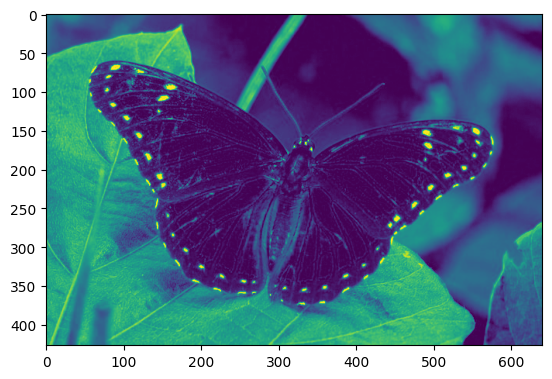

In [20]:
# plt.imshow(image_data[:,:,0])
# plt.imshow(image_data[:,:,1])
plt.imshow(image_data[:,:,2])

### Свертка изображения

In [3]:
import torch
from torch.nn.functional import conv2d

In [30]:
image_tensor = torch.tensor([image_data], dtype=torch.float)
image_tensor.shape

torch.Size([1, 427, 640, 3])

In [31]:
image_tensor = image_tensor.permute(0, 3, 1, 2)
image_tensor.size()

torch.Size([1, 3, 427, 640])

In [45]:
def Sobel(image, bounds='vertical'):
    sobel_mask = np.array([
        [-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]
    ])
    if bounds == 'vertical':
        sobel_mask = sobel_mask.T
    
    kernel = torch.tensor([[sobel_mask, sobel_mask, sobel_mask]], dtype=torch.float)
    img_conv_hor = conv2d(image, kernel)
    img_conv_hor = img_conv_hor.permute(0, 2, 3, 1)
    plt.title(f"{bounds} highlighting")
    plt.imshow(torch.abs(img_conv_hor[0, :, :, 0]))

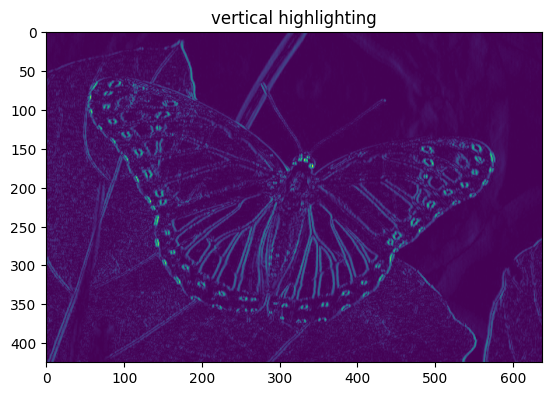

In [48]:
Sobel(image_tensor)

In [108]:
def custom_transform(image):
    mask = np.random.randint(-6, 6, (3, 3))
    kernel = torch.tensor([[mask, mask, mask]], dtype=torch.float)
    transformed_image = conv2d(image, kernel)
    transformed_image = transformed_image.permute(0, 2, 3, 1)
    plt.imshow(torch.abs(transformed_image[0, :, :, 0]))

def simulative(max_iterations):
    for i in range(max_iterations):
        for j in range(max_iterations):
            plt.subplot(max_iterations, max_iterations, i * max_iterations + j + 1)
            custom_transform(image_tensor)

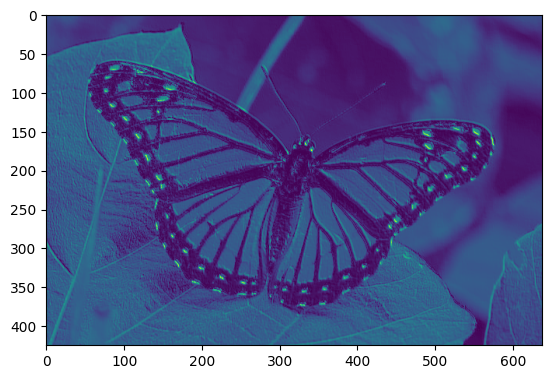

In [109]:
custom_transform(image_tensor)

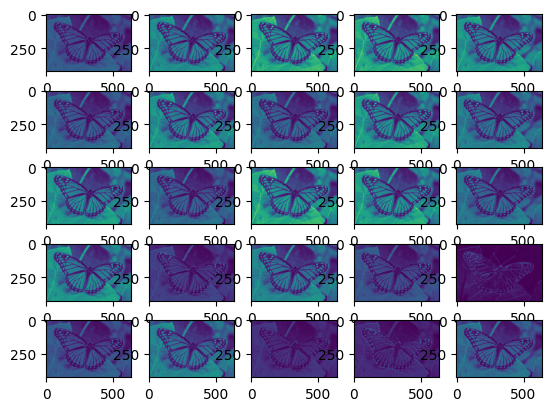

In [103]:
simulative(5)

### Полносвязная нейронная сеть

In [4]:
import torch 
import torch.nn.functional as F
import torchvision
from torch import nn

Downloading MNIST...

In [5]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307, ), (0.3081))
    ]
)

mnist_train = torchvision.datasets.MNIST(
    "./mnist/",
    train=True,
    download=False,
    transform=transform
)

mnist_test = torchvision.datasets.MNIST(
    "./mnist/",
    train=False,
    download=False,
    transform=transform
)

In [6]:
train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True)

In [7]:
batch_sample = next(iter(train_dataloader))
for tensor in batch_sample:
    print(tensor.size())

torch.Size([64, 1, 28, 28])
torch.Size([64])


Text(0.5, 1.0, 'True label is 5')

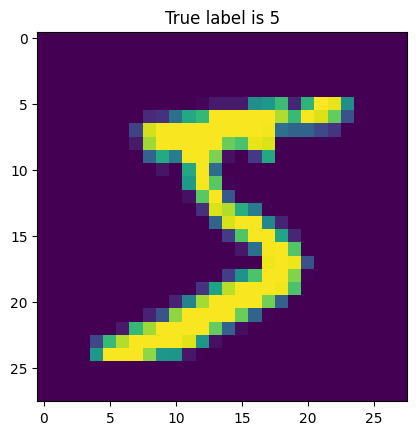

In [8]:
plt.imshow(mnist_train[0][0].squeeze(0).numpy())
plt.title(f"True label is {mnist_train[0][1]}")

In [9]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax()
        )

    def forward(self, image):
        output = self.model(image)
        return output

In [11]:
baseline = LinearModel()
print(baseline.forward(mnist_train[0][0]).argmax(dim=1))

tensor([4])


In [152]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
optimizer = torch.optim.SGD(baseline.parameters(), lr=0.001)

def train(model, optimizer, n_epochs=5):
    for epoch in range(n_epochs):
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in test_dataloader:
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())
            print(f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}")

In [153]:
train(baseline, optimizer, 10)

100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:11<00:00, 80.01it/s]


Epoch: 0, loss: 1.6708873510360718, accuracy: 0.8663


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 69.17it/s]


Epoch: 2, loss: 1.648073673248291, accuracy: 0.8768


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 71.26it/s]


Epoch: 4, loss: 1.6319983005523682, accuracy: 0.8853


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 71.36it/s]


Epoch: 6, loss: 1.6201485395431519, accuracy: 0.8899


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 69.54it/s]


Epoch: 8, loss: 1.611997127532959, accuracy: 0.8932


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 69.90it/s]


## Сверточный слой

In [13]:
class ConvModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4),
            nn.Flatten(),
            nn.Linear(6 * 6 * 10, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, image):
        output = self.model(image)
        return output

In [14]:
conv_model = ConvModel()
optimizer = torch.optim.SGD(conv_model.parameters(), lr=0.01)

In [159]:
train(conv_model, optimizer, 10)

100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:15<00:00, 62.48it/s]


Epoch: 0, loss: 0.2682395577430725, accuracy: 0.9183


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:16<00:00, 55.30it/s]


Epoch: 2, loss: 0.11969329416751862, accuracy: 0.9667


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:18<00:00, 49.68it/s]


Epoch: 4, loss: 0.09031012654304504, accuracy: 0.9714


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:17<00:00, 53.27it/s]


Epoch: 6, loss: 0.0732540711760521, accuracy: 0.9762


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:17<00:00, 53.01it/s]


Epoch: 8, loss: 0.06749933958053589, accuracy: 0.9791


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:18<00:00, 50.78it/s]


## Task II. Your first conv2d network

In [15]:
class MyConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(4 * 4 * 20, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, image):
        return self.model(image)

In [20]:
from torchviz import make_dot

my_conv_nn = MyConvNet()
x_sample, y_sample = next(iter(train_dataloader))
y = my_conv_nn(x_sample)
dot = make_dot(y, params=dict(my_conv_nn.named_parameters()))
dot.render("net_architecture", format="png")  # Сохраняем граф в файл

In [172]:
optimizer = torch.optim.SGD(my_conv_nn.parameters(), lr=0.01)
train(my_conv_nn, optimizer)

100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:17<00:00, 53.30it/s]


Epoch: 0, loss: 0.32497456669807434, accuracy: 0.9043


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:19<00:00, 47.46it/s]


Epoch: 2, loss: 0.1333208978176117, accuracy: 0.9589


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:20<00:00, 46.48it/s]


Epoch: 4, loss: 0.08449266850948334, accuracy: 0.9716


Качество значительно улучшилось 